In [1]:
import sounddevice as sd
from scipy.io.wavfile import write, read
import numpy as np
import matplotlib.pyplot as plt

In [2]:
fs = 44100  # Sample rate
seconds = 10  # Duration of recording
# Channel L = index 0
# Channel R = index 1

myrecording = sd.rec(int(seconds * fs), samplerate=fs, channels=2)
sd.wait()  # Wait until recording is finished
write('output.wav', fs, myrecording)  # Save as WAV file 



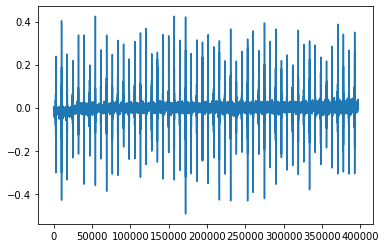

In [3]:
my_sound = myrecording[fs:,1]
plt.figure()
plt.plot(my_sound)
plt.show()

In [4]:
# Count number of ticks in the recording,
# assuming that each tick lasts less than 1000 samples
# (Interval of 0.1 seconds (10 Hz) is 4410 samples)
def count_ticks(sound, threshold):
    count = 0
    i = 0
    while i < len(sound):
        sample = sound[i]
        if sample > threshold:
            count += 1
            i += 1000
        else:
            i += 1
    return count

In [5]:
# Returns the index of the first peak
def find_first_peak(sound, threshold):
    peak_val = threshold
    max_i = None
    i = 0
    while i < len(sound):
        sample = sound[i]
        if sample > threshold:
            peak_val = max(sound[i:i+1000])
            return np.where(sound==peak_val)[0][0]
        else:
            i += 1
    return max_i

# Returns the index of the last peak
def find_last_peak(sound, threshold):
    i = len(sound) - 1
    max_i = None
    peak_val = threshold
    while i >= 0:
        sample = sound[i]
        if sample > threshold:
            peak_val = max(sound[i-1000:i])
            return np.where(sound==peak_val)[0][0]
        else:
            i -= 1
    return max_i

In [6]:
def find_threshold(sound, target_freq=6):
    # Perform binary search on threshold until we get within 5% of target freq
    upper_thresh = 1
    lower_thresh = 0
    thresh = 0.5
    last_freq = -1
    trimmed = sound[find_first_peak(sound, thresh):find_last_peak(sound, thresh)]
    if len(trimmed)/fs <= 1:
        return 0
    stuck = 0
    while stuck < 3:
        freq = (count_ticks(trimmed, thresh) - 1) / (len(trimmed)/fs)
        if freq > target_freq:
            if abs(freq - target_freq) > abs(last_freq - target_freq):
                # If the previous answer was better, then return the previous answer
                return thresh * 2
            thresh = (thresh + upper_thresh) / 2
            lower_thresh = thresh
        elif freq <= target_freq:
            if abs(freq - target_freq) > abs(last_freq - target_freq):
                # If the previous answer was better, then return the previous answer
                return thresh / 2
            thresh = (lower_thresh + thresh) / 2
            upper_thresh = thresh
        # If we didn't make a progress, then increase stuck counter
        # Otherwise reset the stuck counter
        if abs(freq - last_freq) <= 0.0001:
            stuck += 1
        else:
            stuck = 0
        last_freq = freq
    return thresh

In [7]:
# Expect 3000 ish
thresh = find_threshold(my_sound)
first = find_first_peak(my_sound, thresh)
first

2976

In [8]:
thresh

0.0625

In [9]:
last = find_last_peak(my_sound, thresh)
last

392534

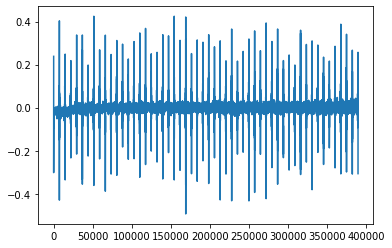

In [10]:
plt.figure()
plt.plot(my_sound[first:last])
plt.show()

In [11]:
trimmed = my_sound[first:last]
count_ticks(trimmed, thresh)

54

In [12]:
freq = (count_ticks(trimmed, thresh) - 1) / (len(trimmed)/fs)

In [13]:
freq

5.999876783431478

In [14]:
def get_beat_error(freq, target_freq=6):
    num_seconds_a_day = 24*60*60
    one_clock_incment = 1/target_freq
    num_clock_seconds_a_day = freq * num_seconds_a_day * one_clock_incment
    return num_clock_seconds_a_day - num_seconds_a_day

In [15]:
get_beat_error(freq, 6)

-1.7743185867147986